# Introduction

QA plots for the TPC detector

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

## `pyROOT` env check

In [3]:
import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

Welcome to JupyROOT 6.22/02


via sPHENIX software distribution at `/cvmfs/sphenix.sdcc.bnl.gov/gcc-8.3/release/release_new/new.3`

In [4]:
%%cpp -d

#include "sPhenixStyle.C"
#include <TStyle.h>

In [5]:
%%cpp

SetsPhenixStyle();
gStyle->SetOptStat(0);
gStyle->SetOptFit(1111);
TVirtualFitter::SetDefaultFitter("Minuit2");

gSystem->Load("libg4eval.so");

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


In [6]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
import numpy as np
import glob
mpl.style.use('seaborn-talk')

# Input

In [7]:
presure_selection = 'Hadron worst tail'

g4score_list = '/phenix/u/jinhuang/links/sPHENIX_work/Fluence/ecce-dose-pgas-1/g4score.lst'

vertex_range = 5 # m
nvertex_scores = 1000

df_presure=pd.read_excel('Detector chamber 211004.presure.xlsx')
df_presure

,X axis,z,Electron Worst Tail,Hadron worst tail,Electron no tail,Hadron no tail
0,0,-5.000000,7.359170e-09,9.039060e-10,7.250410e-09,8.946860e-10
1,1,-4.904040,7.633110e-09,1.580840e-09,7.550200e-09,1.575900e-09
2,2,-4.808081,7.865360e-09,2.251600e-09,7.781000e-09,2.246580e-09
3,3,-4.712121,8.026790e-09,2.936410e-09,7.955490e-09,2.917410e-09
4,4,-4.616162,8.141540e-09,3.612150e-09,8.050210e-09,3.581040e-09
...,...,...,...,...,...,...
95,95,4.116162,5.937010e-09,3.508640e-09,5.895290e-09,3.514600e-09
96,96,4.212121,5.638970e-09,2.884450e-09,5.577620e-09,2.919760e-09
97,97,4.308081,5.333230e-09,2.243330e-09,5.301540e-09,2.287740e-09
98,98,4.404040,5.041300e-09,1.591890e-09,5.012220e-09,1.610000e-09


## Normalization

In [8]:
vertex_bin_size = 2*vertex_range / nvertex_scores # m

print (f"vertex_bin_size = {vertex_bin_size} m")

# 1/fb EIC collision count
eic_collision_fb = 1e15 * 50e-6;
# per-bin normalize towards beam gas interaction for per 1/fb EIC collision at 500kHz per mbar of beam gas
normalization =(eic_collision_fb / 500e3) * 13e3/10/1e-9 * vertex_bin_size; # 13kHz / 10m / 1e-9mbar

print (f"Crosscheck: 10m 10^-9 mbar beam gas interaction rate = {normalization * 1e-9 * (10/vertex_bin_size) / (eic_collision_fb) * 500} kHz")

vertex_bin_size = 0.01 m
Crosscheck: 10m 10^-9 mbar beam gas interaction rate = 12.999999999999998 kHz


## Presure table pre-processing

In [9]:
df_presure['z_exp'] = df_presure['z'] * -1
df_presure.set_index('z_exp', inplace=True)
df_presure = df_presure.sort_index(ascending=True)
df_presure

,X axis,z,Electron Worst Tail,Hadron worst tail,Electron no tail,Hadron no tail
z_exp,,,,,,
-4.500000,99,4.500000,4.729540e-09,8.972960e-10,4.725260e-09,9.126760e-10
-4.404040,98,4.404040,5.041300e-09,1.591890e-09,5.012220e-09,1.610000e-09
-4.308081,97,4.308081,5.333230e-09,2.243330e-09,5.301540e-09,2.287740e-09
-4.212121,96,4.212121,5.638970e-09,2.884450e-09,5.577620e-09,2.919760e-09
-4.116162,95,4.116162,5.937010e-09,3.508640e-09,5.895290e-09,3.514600e-09
...,...,...,...,...,...,...
4.616162,4,-4.616162,8.141540e-09,3.612150e-09,8.050210e-09,3.581040e-09
4.712121,3,-4.712121,8.026790e-09,2.936410e-09,7.955490e-09,2.917410e-09
4.808081,2,-4.808081,7.865360e-09,2.251600e-09,7.781000e-09,2.246580e-09


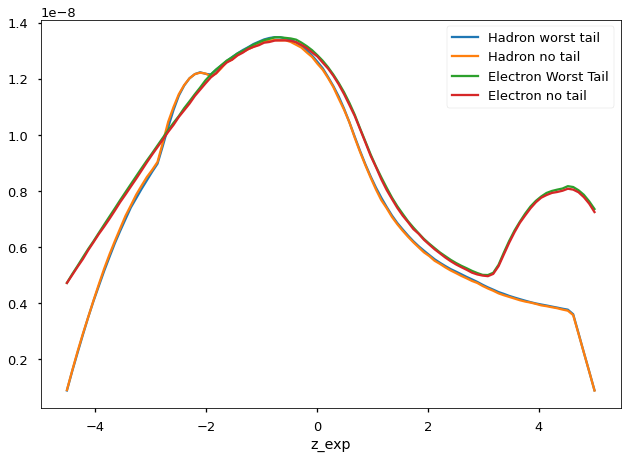

In [10]:

df_presure.plot( y = ['Hadron worst tail', 'Hadron no tail', 'Electron Worst Tail', 'Electron no tail'])

plt.show()

In [11]:
series_presure = df_presure[presure_selection]

np.interp(5, df_presure.index.to_numpy(), df_presure[presure_selection].to_numpy())

9.03906e-10

### Interpolation test

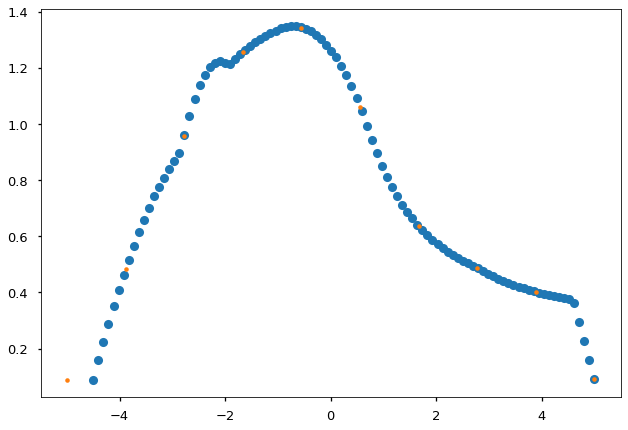

In [12]:
import matplotlib.pyplot as plt
plt.plot(df_presure.index.to_numpy(), df_presure['Hadron worst tail'].to_numpy()*1e8, 'o')
plt.plot(np.linspace(-5, 5, 10), np.interp(np.linspace(-5, 5, 10), df_presure.index.to_numpy(), df_presure['Hadron worst tail'].to_numpy()*1e8), '.')
plt.show()

# G4score weighting

In [13]:
g4score_list_file = open(g4score_list, 'r')
 
    
output_histograms = {};
output_file = ROOT.TFile.Open(g4score_list + "_"+ presure_selection+ '_weighted.root',"recreate")

counter = 0
for g4score_file_name in  g4score_list_file.readlines():
    
    counter = counter +1
    assert(counter<=nvertex_scores )
    
    g4score_file_name = g4score_file_name.rstrip("\n")
    print (f"Processing {g4score_file_name} ...")
    
    input_file = ROOT.TFile.Open(g4score_file_name)
    assert(input_file.IsOpen())
    
    if (counter==1):
        input_file.ls();
        
        #make output file
        
        assert(output_file.IsOpen())
        output_file.cd()
        for key in input_file.GetListOfKeys():
            print (f"Cloning {key} ...")
            h = key.ReadObj()
            
            h_reweight = h.Clone();
            h_reweight.Reset();
            h_reweight.SetDirectory(output_file)
            output_histograms[key.GetName()] = h_reweight

    z_binID = int(os.path.basename(g4score_file_name).split("_")[0])
    z_forThisFile = vertex_bin_size*z_binID - vertex_range
    pressure_forThisFile = np.interp(z_forThisFile, df_presure.index.to_numpy(), df_presure[presure_selection].to_numpy())
    input_event_count = input_file.Get("hNormalization").GetBinContent(3);
    normalization_forThisFile = normalization / input_event_count * pressure_forThisFile
    print (f"\tFile ID {z_binID} @ z = {z_forThisFile} m with presure {pressure_forThisFile} mbar, containing {input_event_count} events, normalization_forThisFile = {normalization_forThisFile}")
            
    
    for key in input_file.GetListOfKeys():
        h = key.ReadObj()
        output_histograms[key.GetName()].Add(h, normalization_forThisFile);
        
        
    input_file.Close()
    
#     break # test
    
output_file.cd()

# for h in output_histograms:
#     print (f"Write {h.GetName()}")
#     h.Write()

output_file.Write();
        
print (f"Output to:")
output_file.ls()

assert (nvertex_scores == counter)

Processing /phenix/u/jinhuang/links/sPHENIX_work/Fluence/ecce-dose-pgas-1/1000_g4score.root ...
Cloning Name: hNChEta Title: Charged particle #eta distribution ...
Cloning Name: hNormalization Title: Normalization ...
Cloning Name: hScore_FullCylinder_dose Title: Mesh FullCylinder, Primitive scorer dose: score [Gy] ...
Cloning Name: hScore_FullCylinder_edep Title: Mesh FullCylinder, Primitive scorer edep: score [MeV] ...
Cloning Name: hScore_FullCylinder_flux_charged Title: Mesh FullCylinder, Primitive scorer flux_charged: score [percm2] ...
Cloning Name: hScore_FullCylinder_flux_charged_EkMin1MeV Title: Mesh FullCylinder, Primitive scorer flux_charged_EkMin1MeV: score [percm2] ...
Cloning Name: hScore_FullCylinder_flux_charged_EkMin20MeV Title: Mesh FullCylinder, Primitive scorer flux_charged_EkMin20MeV: score [percm2] ...
Cloning Name: hScore_FullCylinder_flux_neutron Title: Mesh FullCylinder, Primitive scorer flux_neutron: score [percm2] ...
Cloning Name: hScore_FullCylinder_flux_ne

In [14]:
int(os.path.basename("/phenix/u/jinhuang/links/sPHENIX_work/Fluence/ecce-dose-pgas-1/1000_g4score.root").split("_")[0])

1000

## Output normalization check

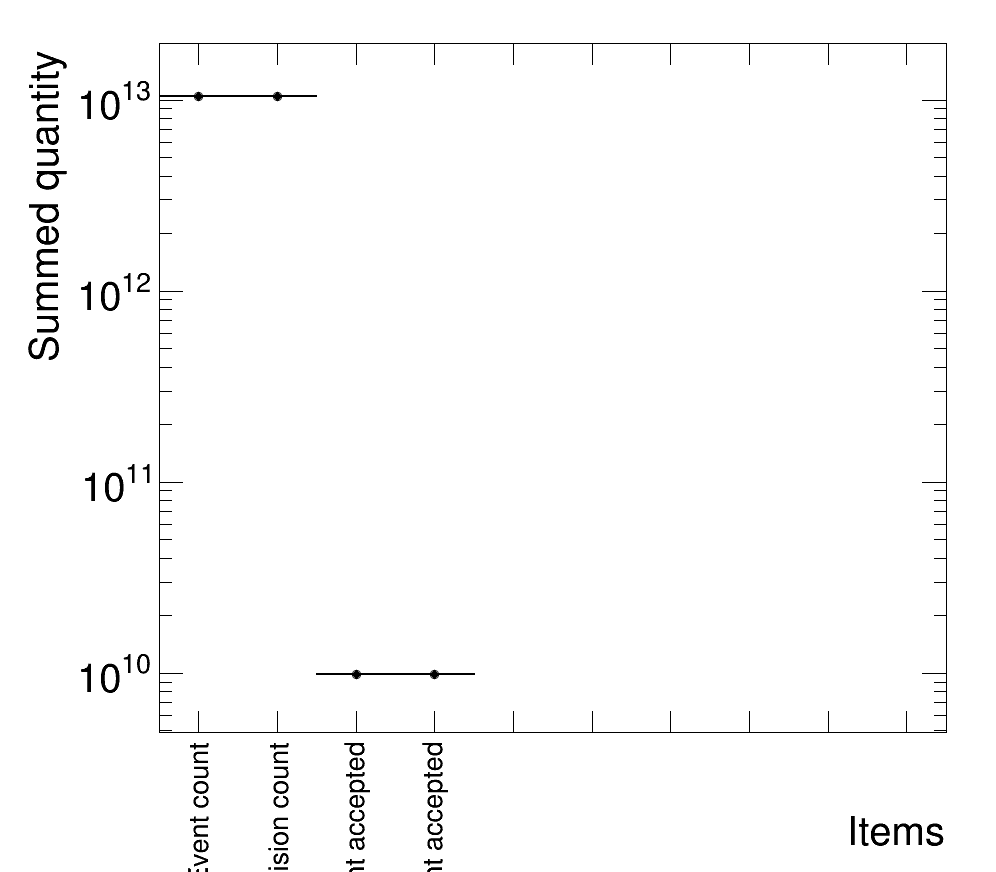

In [15]:
c1 = ROOT.TCanvas( 'TrackQA', 'TrackQA', 1000, 900)

ROOT.gPad.SetLogy();
output_histograms["hNormalization"].Draw();

c1.Draw()

In [19]:
f"{100e15 * 50e-6 / 100:e}"

'5.000000e+10'

In [17]:
output_histograms

{'hNChEta': <cppyy.gbl.TH1D object at 0xaa24980>,
 'hNormalization': <cppyy.gbl.TH1D object at 0xaa51e00>,
 'hScore_FullCylinder_dose': <cppyy.gbl.TH3D object at 0xaa760d0>,
 'hScore_FullCylinder_edep': <cppyy.gbl.TH3D object at 0xaabf7a0>,
 'hScore_FullCylinder_flux_charged': <cppyy.gbl.TH3D object at 0xbcdfed0>,
 'hScore_FullCylinder_flux_charged_EkMin1MeV': <cppyy.gbl.TH3D object at 0xc5cc650>,
 'hScore_FullCylinder_flux_charged_EkMin20MeV': <cppyy.gbl.TH3D object at 0xc5d9f60>,
 'hScore_FullCylinder_flux_neutron': <cppyy.gbl.TH3D object at 0xcec5730>,
 'hScore_FullCylinder_flux_neutron_EkMin100keV': <cppyy.gbl.TH3D object at 0xd7bd0c0>,
 'hScore_FullCylinder_flux_neutron_EkMin1MeV': <cppyy.gbl.TH3D object at 0xcec4990>,
 'hVertexZ': <cppyy.gbl.TH1D object at 0xceba190>}

In [18]:
key.GetName()

'TList'